# First Attempt with Resnet

- Author : Areeb Islam
- Github : are021

In [ ]:
! pip install --upgrade torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.

In [3]:
import torch
from torchvision import transforms, datasets
from PIL import Image

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Freeze layers
for param in model.parameters():
  param.requires_grad = False

## Binary Classification

In [ ]:
num_features = model.fc.in_features

# Change last layer to binary (recyclable or non-recyclable)
# We may need to change this architecture to first classify is recyclable, then contaminated
model.fc = torch.nn.Linear(num_features, 2)

In [ ]:
model.eval()

In [ ]:
# Define the image transform
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load our dataset
I am using this dataset I found on kaggle, I want to just give it a try and test it's validity.

In [ ]:
! mkdir .kaggle

In [ ]:
! chmod 600 .kaggle/kaggle.json


In [ ]:
! kaggle datasets download techsash/waste-classification-data/

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data/versions/
License(s): CC-BY-SA-4.0
 99% 421M/427M [00:06<00:00, 100MB/s] 
100% 427M/427M [00:06<00:00, 71.0MB/s]


In [ ]:
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

In [ ]:
test_path = '/content/dataset/DATASET/TEST'
train_path = '/content/dataset/DATASET/TRAIN'

In [ ]:
training_data = datasets.ImageFolder(train_path, transform=preprocess)
training_data

Dataset ImageFolder
    Number of datapoints: 22564
    Root location: /content/dataset/DATASET/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
testing_data = datasets.ImageFolder(test_path, transform=preprocess)
testing_data

Dataset ImageFolder
    Number of datapoints: 2513
    Root location: /content/dataset/DATASET/TEST
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
first_image = testing_data[0][0]
first_image.size()

torch.Size([3, 224, 224])

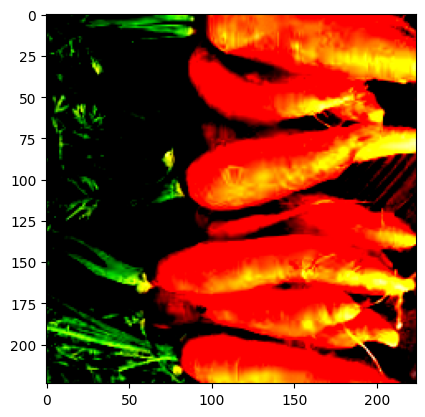

In [ ]:
# Lets visualize the image
import matplotlib.pyplot as plt
import numpy as np

first_image_np = first_image.numpy()

plt.imshow(first_image_np.T, cmap='gray')
plt.show()

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# Define the dataloader
batch_size = 32

training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_dataloader =  DataLoader(testing_data, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# define number of epochs
num_epochs = 10

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

loss_values = []
epoch_values = []

for epoch in range(num_epochs):
    model.train(True)
    running_loss = 0.0
    for inputs, labels in tqdm(training_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_values.append(running_loss / len(training_data))
    epoch_values.append(epoch+1)
    print(f'Epoch {epoch+1} loss: {running_loss / len(training_data)}')

100%|██████████| 706/706 [01:44<00:00,  6.78it/s]


Epoch 1 loss: 0.005841337781243635


100%|██████████| 706/706 [01:44<00:00,  6.75it/s]


Epoch 2 loss: 0.00564640457126923


100%|██████████| 706/706 [01:42<00:00,  6.89it/s]


Epoch 3 loss: 0.0057730764771226056


100%|██████████| 706/706 [01:42<00:00,  6.86it/s]


Epoch 4 loss: 0.005635735941557169


100%|██████████| 706/706 [01:42<00:00,  6.88it/s]


Epoch 5 loss: 0.0058099816763300385


100%|██████████| 706/706 [01:42<00:00,  6.89it/s]


Epoch 6 loss: 0.005736101228044433


100%|██████████| 706/706 [01:42<00:00,  6.89it/s]


Epoch 7 loss: 0.005630029450528795


100%|██████████| 706/706 [01:41<00:00,  6.98it/s]


Epoch 8 loss: 0.005704032122891379


100%|██████████| 706/706 [01:42<00:00,  6.88it/s]


Epoch 9 loss: 0.0055756329360175825


100%|██████████| 706/706 [01:41<00:00,  6.93it/s]

Epoch 10 loss: 0.005604659908009831


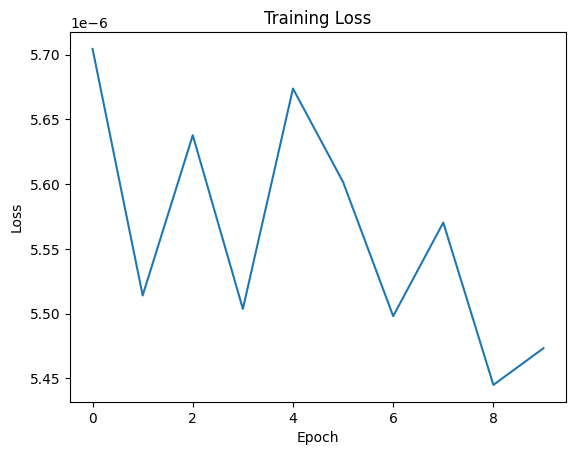

[1.782634820936168e-07, 1.7231459262906585e-07, 1.761803124121889e-07, 1.7198901188834135e-07, 1.7730656971222041e-07, 1.7505191735975442e-07, 1.7181486360256332e-07, 1.7407324593784726e-07, 1.701548137212397e-07, 1.7104064660674533e-07]


In [ ]:
plt.plot(epoch_values, loss_values)
loss_values = [loss / batch_size for loss in loss_values]
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
print(loss_values)

In [ ]:
"path = './model'
torch.save(model.state_dict(), path)

In [ ]:
def calculate_accuracy(model, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = calculate_accuracy(model, testing_dataloader, device)
print(f'\nTest accuracy: {test_accuracy:.2f}%')

100%|██████████| 79/79 [00:14<00:00,  5.55it/s]


Test accuracy: 90.77%


# Using Adam Optimizer

In [ ]:
num_epochs = 20

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

loss_values = []
epoch_values = []

for epoch in range(num_epochs):
    model.train(True)
    running_loss = 0.0
    for inputs, labels in tqdm(training_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_values.append(running_loss / len(training_data))
    epoch_values.append(epoch+1)
    print(f'Epoch {epoch+1} loss: {running_loss / len(training_data)}')

100%|██████████| 706/706 [01:46<00:00,  6.63it/s]


Epoch 1 loss: 0.005837679278462771


100%|██████████| 706/706 [01:46<00:00,  6.63it/s]


Epoch 2 loss: 0.00586295888058021


100%|██████████| 706/706 [01:44<00:00,  6.77it/s]


Epoch 3 loss: 0.005684912857130511


100%|██████████| 706/706 [01:45<00:00,  6.71it/s]


Epoch 4 loss: 0.005798482416589602


100%|██████████| 706/706 [01:44<00:00,  6.77it/s]


Epoch 5 loss: 0.005588007028360086


100%|██████████| 706/706 [01:45<00:00,  6.70it/s]


Epoch 6 loss: 0.005869531683211704


 79%|███████▉  | 560/706 [01:21<00:20,  7.27it/s]

In [ ]:
plt.plot(epoch_values, loss_values)
loss_values = [loss / batch_size for loss in loss_values]
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
print(loss_values)

## Multiclass Classification and Transfer Learning

This model will classify the material the image is made of, and then we will discern if the item is recyclable or not. We will test accuracy using different resnet models

In [6]:
import os

In [7]:
model_structure = 'resnet18'

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', model_structure, pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Freeze layers
for param in model.parameters():
  param.requires_grad = False

In [10]:
num_features = model.fc.in_features

# 6 outputs based on our dataset
model.fc = torch.nn.Linear(num_features, 6)

## Data Processing

In [11]:
! mkdir .kaggle

In [12]:
! chmod 600 .kaggle/kaggle.json


In [13]:
! kaggle datasets download asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 98% 80.0M/82.0M [00:00<00:00, 104MB/s] 
100% 82.0M/82.0M [00:00<00:00, 105MB/s]


In [14]:
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

In [15]:
# Define the image transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
path = os.path.join(os.getcwd(), 'garbage classification', 'Garbage classification')
dataset = datasets.ImageFolder(path, transform=transform)
total = len(dataset)

In [17]:
# I'm going to now add a validation set, to ensure our model is being trained properly
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
validation_size = total - train_size - test_size

#Confirm they match
print("Do train,test,val sizes match? :", train_size + test_size + validation_size == total)


Do train,test,val sizes match? : True


In [18]:
train, test, val = torch.utils.data.random_split(dataset, [train_size, test_size, validation_size])

In [19]:
import matplotlib.pyplot as plt

unique_items = {0: None, 1: None, 2: None, 3: None, 4: None, 5: None}
for item in train:
    label = item[1]
    if unique_items[label] is None:
        unique_items[label] = item[0]

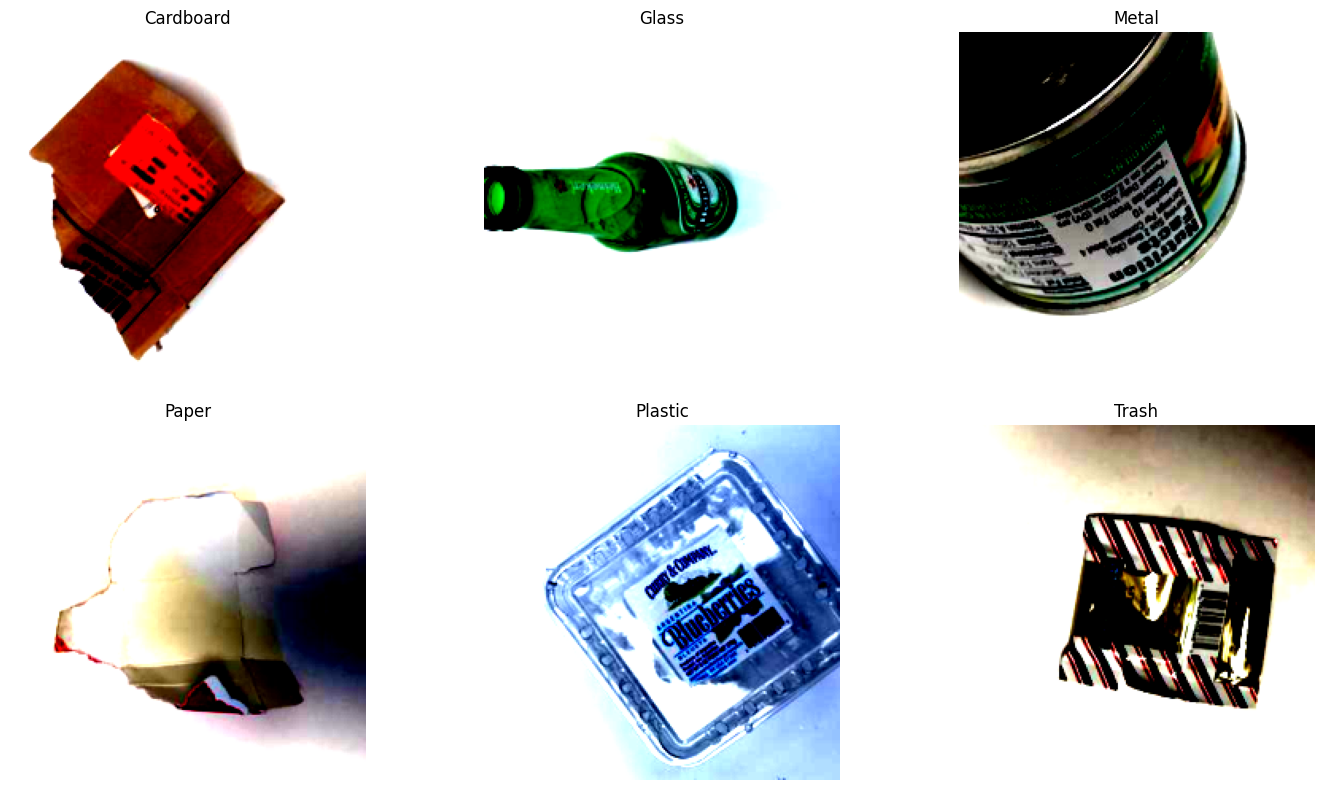

In [25]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))  # Create a 2x3 grid of subplots
axs = axs.ravel()  # Flatten the list of axes
items = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

for i, (key, image) in enumerate(unique_items.items()):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"{items[i]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [30]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [31]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [39]:
len(train_loader)

64

In [32]:
num_epochs = 10

In [37]:
## Train and Validate
training_loss = []
for epoch in range(num_epochs):
  model.train(True)
  running_loss = 0.0
  total_images = 0
  for inputs, labels in tqdm(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

epochs = 5
min_valid_loss = np.inf

for epoch in range(num_epochs):
  model.train(True)
  train_loss = 0.0

  for inputs, labels in tqdm(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  valid_loss = 0.0
  model.eval()

  for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)
    target = model(data)
    loss = criterion(target, labels)
    valid_loss += loss.item()
    for data, labels in trainloader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validloader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()

    print(f'Epoch {e+1} \t\t Training Loss: {\
    train_loss / len(trainloader)} \t\t Validation Loss: {\
    valid_loss / len(validloader)}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f\
        }--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')


100%|██████████| 64/64 [00:10<00:00,  6.31it/s]


64 Training 2021


 44%|████▍     | 28/64 [00:04<00:05,  6.82it/s]


KeyboardInterrupt: 